In [48]:
from functions import *
from scipy.optimize import curve_fit
def fitpowerlaw(x,y,deg):
    def powerlaw(x,coeff):
        return coeff*x**deg
    popt, _ = curve_fit(f=powerlaw, xdata=x, ydata=y)
    return popt

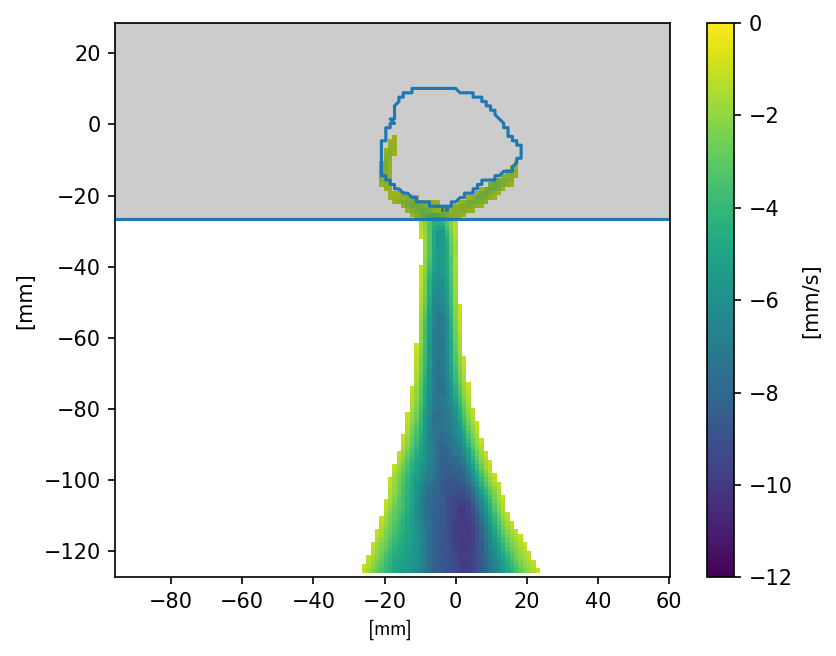

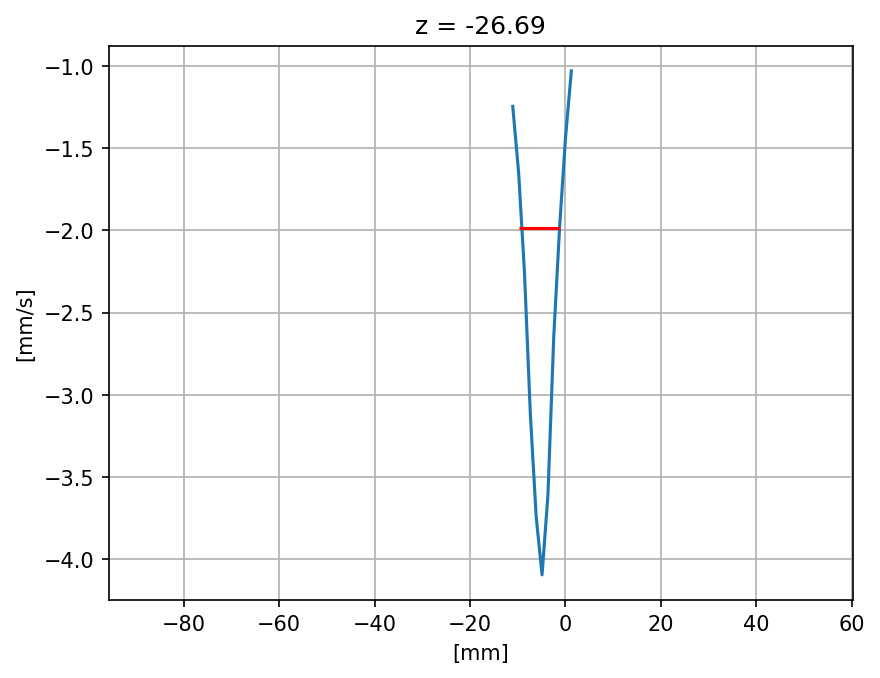

0.1426974016519215 7903041.888511313


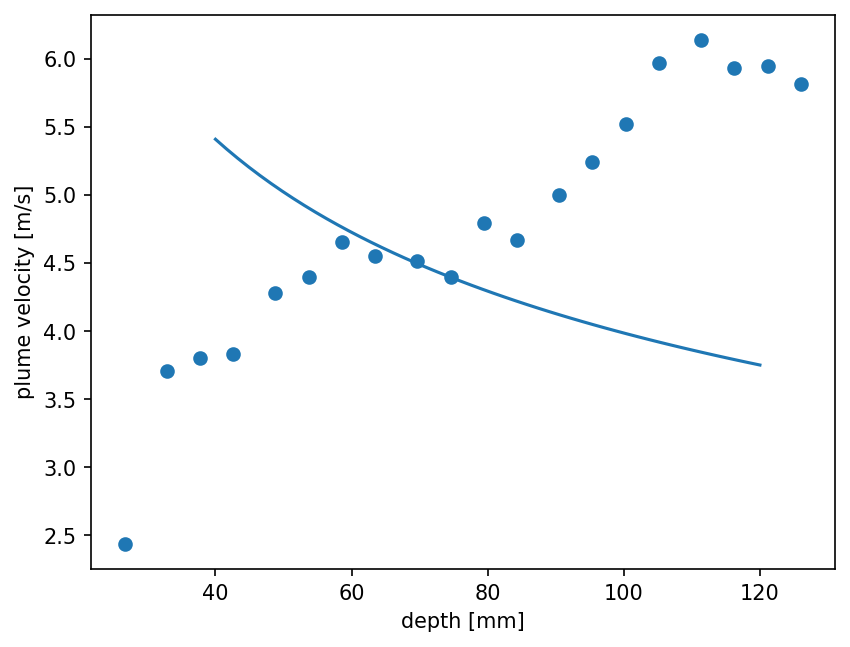

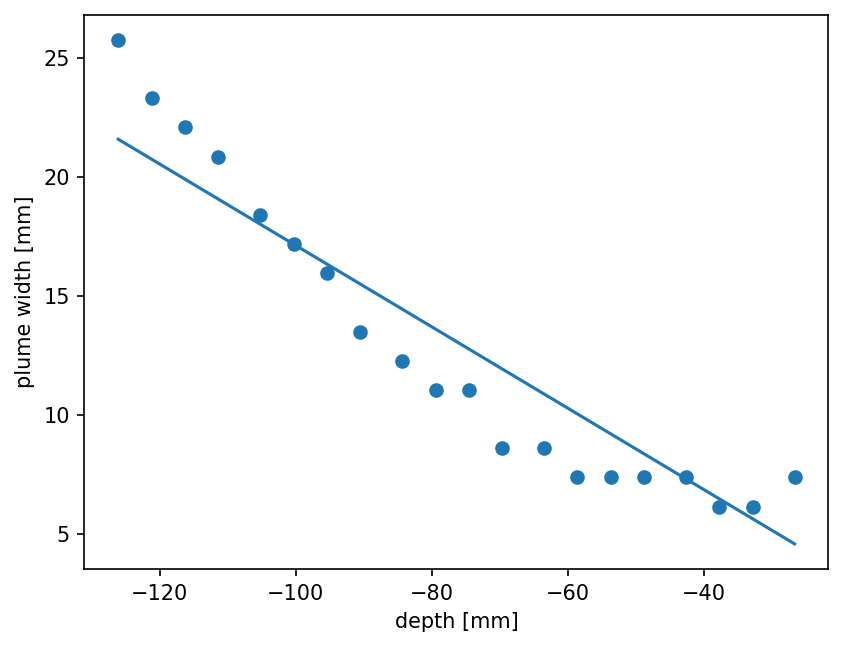

In [205]:
pivDirectory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-06/'
chosen_salt,chosen_radius,chosen_time = 0.,0.025,'112113'#'111632'#'111854'# fresh
# chosen_salt,chosen_radius,chosen_time = 35.,0.025,'111510'#'111226'# #salty

it=-1
folders = []

for folder in glob.glob(pivDirectory+'Cam*'):
    folders.append(folder)
folders = np.sort(folders)

for folder in folders:
    date = folder[93:99]
    time = str(folder[105:111])
    exp_sal = float(folder[113:115])
    exp_radius = int(folder[116:118])/2000
    if exp_radius == 0.006: exp_radius=0.06
    if exp_radius==chosen_radius and exp_sal==chosen_salt and time==chosen_time:
        it +=1
        # read data
        pivData = np.genfromtxt(glob.glob(folder+'/*.txt')[0]).T
        break
    # if it==4:break

x,y,u,v = pivData
# u = np.ma.array(u, mask=mask) # ONLY IF MASK EXISTS
side = np.sqrt(x.shape[0]).astype(int)


# regularly spaced grid spanning the domain of x and y 
xi = np.linspace(x.min(), x.max(), side)
yi = np.linspace(y.min(), y.max(), side)
X,Y = np.meshgrid(xi,yi)

ui = np.reshape(u,(side,side))[::-1,:]
vi = np.reshape(v,(side,side))[::-1,:]

for ic,contourPATH in enumerate(glob.glob(folder+'/*.csv')):
    contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
    if contour.shape[1]!=2: contour = contour.T
indexMinimum = np.min(-(contour/1024*128)[:,1].astype(int))-2 # location of bottom of ice, shifted down to go further from the ice

plt.figure(dpi=150)
cleanVi = np.where(vi>-0.001,np.nan,vi)
im = plt.imshow(cleanVi*1000,extent=(xi[0],xi[-1],yi[-1],yi[0]),vmin=-12,vmax=0)
plt.hlines(yi[indexMinimum],xi[0],xi[-1])
pc = contour/1024*128 # plot contour
plt.plot(xi[pc[:,0].astype(int)],yi[-pc[:,1].astype(int)])
plt.colorbar(im,label='[mm/s]')
plt.fill_between(np.linspace(xi[0],xi[-1],50),yi[indexMinimum],yi[-1],color='k',alpha=0.2)
plt.gca().invert_yaxis()
plt.xlabel('[mm]',usetex=True)
plt.ylabel('[mm]')
plt.show()

plt.figure(dpi=150)
velocityProfile = cleanVi[indexMinimum,:]*1000
plt.plot(xi,velocityProfile)
# plumeVel = np.nanmean(velocityProfile)
plumeVel = np.nansum(velocityProfile)/(np.sum(~np.isnan(velocityProfile))*(xi[1]-xi[0]))
left, right = np.where(np.abs(np.gradient(np.sign(velocityProfile-plumeVel)))==1)[0][0],np.where(np.abs(np.gradient(np.sign(velocityProfile-plumeVel)))==1)[0][-1]
b = abs(xi[left]-xi[right])
plt.hlines(plumeVel,xi[left],xi[right],colors='red')
plt.grid()
plt.xlim(xi[0],xi[-1])
plt.title(f'z = {yi[indexMinimum]:.2f}')
plt.xlabel('[mm]')
plt.ylabel('[mm/s]')
plt.show()

ws = np.array([])
bs = np.array([])
zs = np.array([])

for _,iz in enumerate(np.linspace(-len(yi)+1,indexMinimum,20,dtype=int)):
    # print(iz,yi[iz])
    velocityProfile = cleanVi[iz,:]*1000
    w = np.nanmean(cleanVi[iz,:]*1000)
    left, right = np.where(np.abs(np.gradient(np.sign(velocityProfile-w)))==1)[0][0],np.where(np.abs(np.gradient(np.sign(velocityProfile-w)))==1)[0][-1]
    # test
    # plt.title(yi[iz])
    # plt.plot(xi,velocityProfile)
    # plt.plot(xi,np.abs(np.gradient(np.sign(velocityProfile-w))))
    # plt.hlines(w,xi[left],xi[right],colors='red')
    # plt.grid()
    # plt.show()
    b = abs(xi[left]-xi[right])
    zs = np.append(zs,yi[iz])
    bs = np.append(bs,b)
    ws = np.append(ws,w)
_,ax1 = plt.subplots(dpi=150)
_,ax2 = plt.subplots(dpi=150)
ax1.scatter(-zs,-ws)
ax1.plot(np.linspace(40,120,50),
         fitpowerlaw(x=-zs,y=-ws,deg=-1/3)*np.linspace(40,120,50)**(-1/3))
ax2.scatter(zs,bs)
ax2.plot(zs,fitpowerlaw(zs,bs,1)*zs)
alpha = -5*fitpowerlaw(zs,bs,1)[0]/6
B = (fitpowerlaw(x=zs-np.min(zs)+1,y=-ws,deg=-1/3)[0]*6/5/alpha)**3*10/9/alpha
print(alpha,B)
for axi in [ax1,ax2]:
    axi.set(xlabel='depth [mm]',)
ax1.set(ylabel='plume velocity [m/s]')
ax2.set(ylabel='plume width [mm]')

plt.show()

del pivData